# Assignment IHE Hydrology, Transient Groundwater 2024

Prof. dr.ir. T.N.Olsthoorn 
Feb 18, 2024

# Long-term Nasser Lake Impact on adjacent Groundnwater

Get the data for the Nasser [Lake level](./data/images/NasserLakeLevel1965-2005.csv) over the years 1965-2005.

### The paper with the data:
Elaswwaf M, Feyen J, Batelaan O and Bakr M (2014)
Groundwater-surface water interaction in Lakke Nasser, Southern Egypt. Hydrological Process. 28, 414-430 (2014)

This is one of the pictures, Fig 4D from the paper, showing the Lake Level and the measurements in some of the observation wells and the simulated curves between 1965 and 2005:

![The picuture](./images/nasserLakePaperfig4D.png)



In [166]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.special import erfc
from itertools import cycle
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as isdatetime64

sys.path.insert(0, 'Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment')

from Students2024 import students

In [7]:
IHE24 = '/Users/Theo/Entiteiten/IHE/IHE2023-2024/'
ASSIGN = os.path.join(IHE24, 'Assignment')
DATA = os.path.join(ASSIGN, 'data')
IMAG = os.path.join(ASSIGN, 'images')

for d in [IHE24, ASSIGN, DATA, IMAG]:
    assert os.path.isdir(d), 'Directory <{}> not found!'.format(d)

In [202]:
def newfig(title='title', xlabel='xlabel', ylabel='ylabel', xlim=None, ylim=None, xscale=None, yscale=None, figsize=(10., 5)):
    """Set up a new figure and return axis of it."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if figsize:
        fig.set_size_inches = figsize
    return ax
        

## Read the digitized lake level data with years as float

In [180]:
def ft2np(p):    
    """Return np.datetime64 obj from floatin point times.

    Parameters
    ----------
    p: sequence of floats
        representing date of the form yyyy.ffff with fff the fraction of the year

    Returns
    -------
    array of np.datetime64 objects
    
    >>>ft2np([1965.231, 1971.891, 1993.421])
    array(['1965-03-26', '1971-11-22', '1993-06-04'], dtype='datetime64[D]')
    """
    dt, td = np.datetime64, np.timedelta64
    
    p =np.asarray(p, float)
    
    years = np.array([dt('{:.0f}-01-01'.format(np.floor(p_))) for  p_ in p])
    ydays  = np.round((p - np.floor(p)) * np.array(
        [(dt("{:.0f}-01-01".format(np.ceil(p_))) -  dt("{:.0f}-01-01".format(np.floor(p_)))) / td(1, 'D') for p_ in p]))    
    
    return years + ydays * td(1, 'D')

def np2ft(p):
    """Convert array from np.Datetime65 to yyyy.fff float array.

    Parameters
    ----------
    p: array or index of dtype like np.datetime64
        input array or index

    Returns
    -------
    array with dtype float where numbers are yyyy.fff with fff the fraction in the year.
    """
    
    assert isdatetime64(p), 'dtype of input must be like np.datetime64. not {}'.format(p.dtype)
    dt, td = np.datetime64, np.timedelta64
    return (p - p[0]) / td(1, 'D')
    
np2ft(pd_level.index)

#tfrac = ft2np(pd_level.index)
#ft2np([1965.231, 1971.891, 1993.421])

Index([    0.0,    76.0,   126.0,   149.0,   189.0,   216.0,   253.0,   320.0,
         445.0,   522.0,
       ...
       13627.0, 13751.0, 13846.0, 13894.0, 14010.0, 14029.0, 14130.0, 14239.0,
       14319.0, 14388.0],
      dtype='float64', length=206)

In [199]:
fname = os.path.join(DATA, 'NasserLakeLevel1965-2005_digitized_from_paper.csv')
assert os.path.isfile(fname), "can't find file {}".format(fname)

pd_level = pd.read_csv(fname, index_col=0)
pd_level = pd_level.loc[sorted(pd_level.index)]
pd_level.index.name = 'Date'

pd_level.index = ft2np(pd_level.index)
print(pd_level.head(10))

               level
1965-03-12  126.2989
1965-05-27  123.8822
1965-07-16  120.0773
1965-08-08  117.3158
1965-09-17  118.2840
1965-10-14  127.3839
1965-11-20  129.9363
1966-01-26  131.7946
1966-05-31  128.9925
1966-08-16  119.2212


In [250]:
# Convert index to np.datetime64 objects
tfold = np2ft(pd_level.index)
tfnew = np.arange(told[0], told[-1] + 1)
hlake = np.interp(tfnew, tfold, pd_level.values[:, 0])

lake = pd.Series(hlake, index=pd.Index(pd_level.index[0] + tfnew * np.timedelta64(1, 'D'), name='Date'), name='level')

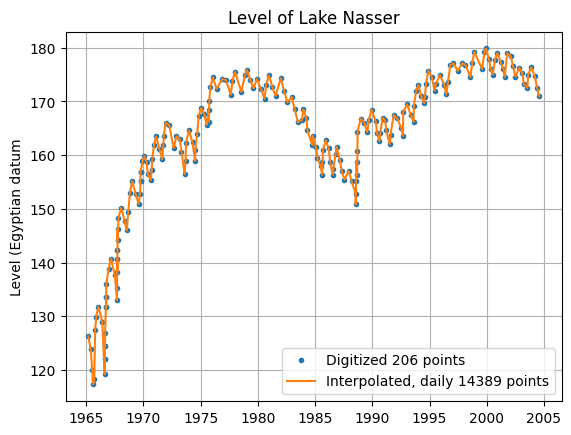

In [198]:
plt.title("Level of Lake Nasser")
plt.ylabel("Level (Egyptian datum")
plt.plot(pd_level, '.', label='Digitized {} points'.format(len(pd_level)))
plt.plot(lake, label='Interpolated, daily {} points'.format(len(lake)))
plt.grid(True)
plt.legend()
plt.show()

The groundwater head in the adjacent aquifer can be computed using the solution for the sudden change of the lake level using the change that occurs at each day.

The changes are if we start our superpostion with the level at the first day:

The analytical solution for the effect of a sudden change of level at $x=0$ is

$$\Delta h = \Delta h_0 \, \mbox{efrc}(u),\,\,\,\,u=\sqrt{\frac{x^2 S}{4 kD t}}$$

In [200]:
def BR_sudden_change(x, tau, kD, S):
    """Return the block response for a sudden lake-level change".
    """
    assert np.isscalar(x), "x must be a float."
    
    tau[0] += 0.5 * (tau[1] - tau[0]) # Prevent division by zero for tau[0]
    T = x ** 2 * S  / (4 * kD)
    u = np.sqrt(T / tau)
    return erfc(np.sqrt(u))
    

### Simulate the head over time for different x values and show the graphs

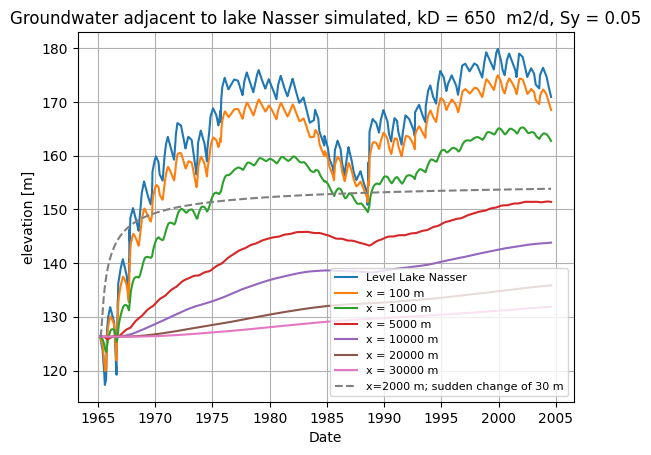

In [204]:
# Daily lake level changes, add 0 in front to keep the length of the series the same.
dhlake = np.hstack((0, np.diff(lake.values)))

# Values for use in the simulation
X = np.array([100, 1000, 5000, 10000, 20000, 30000])
kD, S = 10 * 65, 0.05

# Take the block response as long as the whole series
tau = np.asarray((lake.index - lake.index[0]) / np.timedelta64(1, 'D'), dtype=float)

# Set up the plot
title = 'Groundwater adjacent to lake Nasser simulated, kD = {:.0f}  m2/d, Sy = {:.3g}'.format(kD, S)
ax = newfig(title, 'Date', 'elevation [m]', figsize=(10, 5))

# Show the lake level itself.
ax.plot(lake.index, lake.values, label='Level Lake Nasser')

# Then the heads at the given x-values
for x in X:
    hc = lfilter(BR_sudden_change(x, tau, kD, S), 1, dhlake) + lake[lake.index[0]]
    ax.plot(lake.index, hc, label='x = {:.0f} m'.format(x))

    # pick random points
    L = np.random.choice(np.arange(len(lake)), size=10)
    df = pd.DataFrame(index=lake.index[L], data={'x': np.ones(len(L)) * x, 'h': hc[L]})
    df.index.name='date'
    fname = os.path.join(DATA, 'well_x{:.0f}.csv'.format(x))
    df.sort_index().to_csv(fname, header=True)

# t in days, but floating points to be used in the block response
t = (lake.index - lake.index[0]) / np.timedelta64(1, 'D')

# Just add for comparison with the basic solution for a sudden change
x = 2000
dh = 30

ax.plot(lake.index, lake[lake.index[0]] + dh * erfc(x * np.sqrt(S/ (4 * kD * t))), '--',
        label='x={:.0f} m; sudden change of {} m'.format(x, dh)), 

plt.legend(loc='lower right', fontsize=8)
plt.show()

# Save date for the students

['tolsthoorn@gmail.com', 'Theo_Olsthoorn']


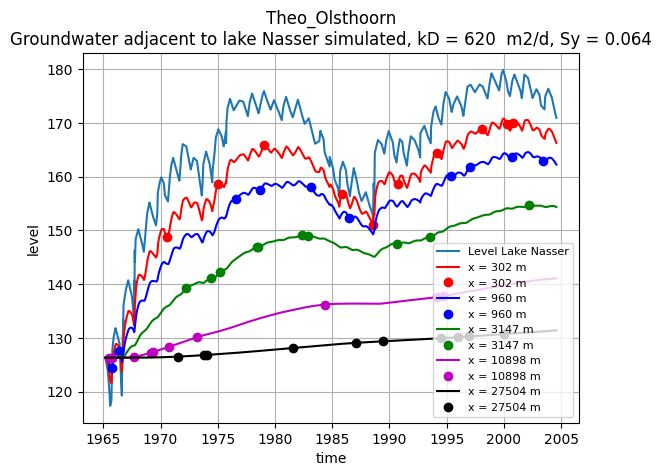

['lnj001@un-ihe.org', 'Lima_Niao']


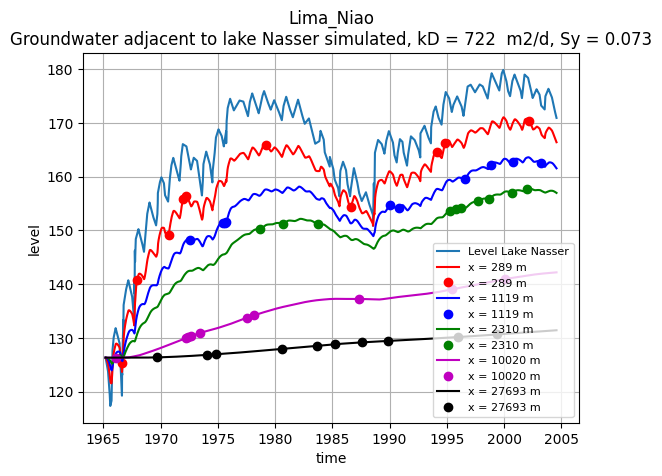

['jtr002@un-ihe.org', 'Joshua_Trotman']


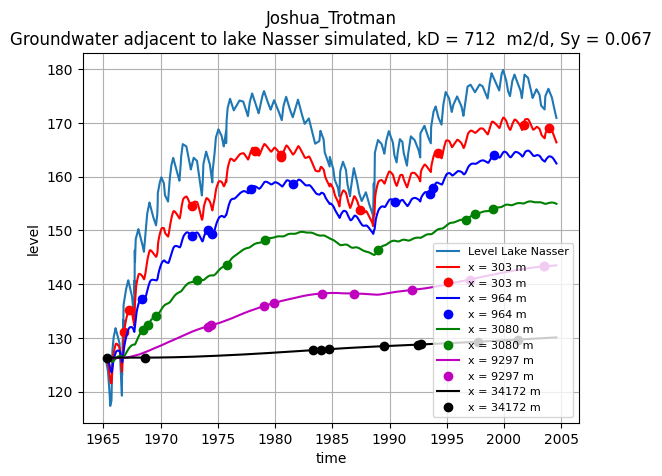

['ynd001@un-ihe.org', 'Joshua_Ndolele']


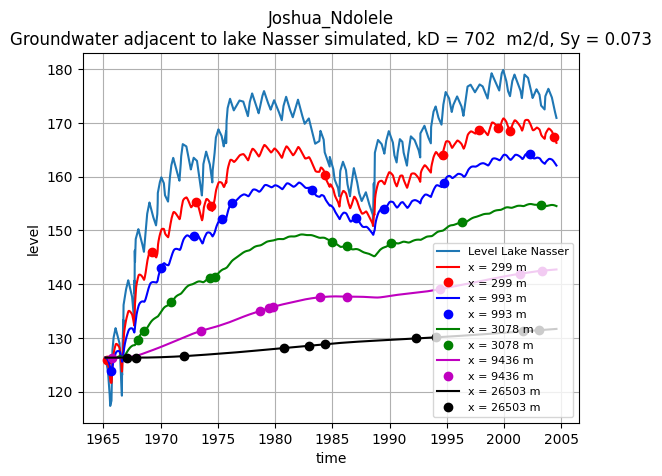

['tka004@un-ihe.org', 'Tamandani_Kamuyanja']


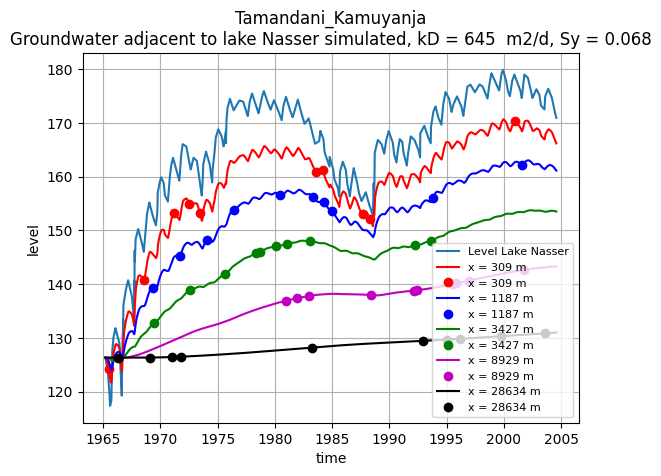

['vur002@un-ihe.org', 'Valentina_Urrea_Vargas']


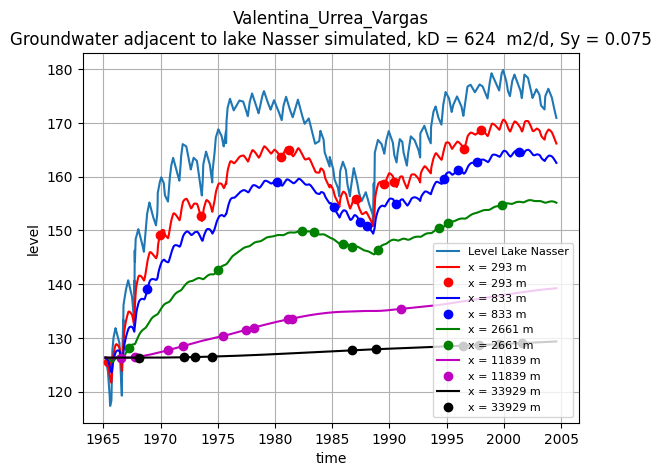

['itu002@un-ihe.org', 'Isaq_Tuna']


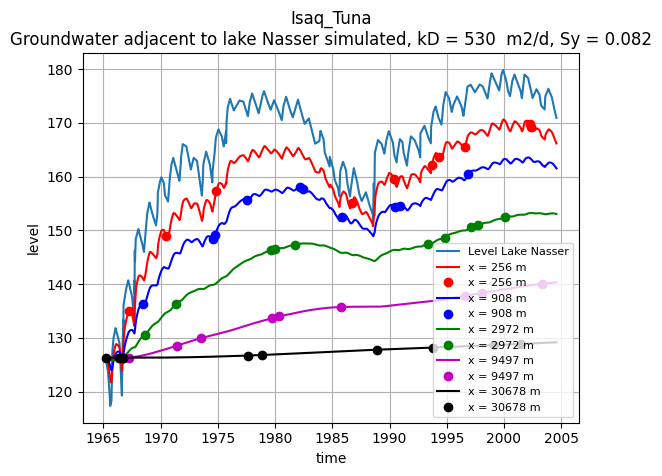

In [260]:
# Daily lake level changes, add 0 in front to keep the length of the series the same.
dhlake = np.hstack((0, np.diff(lake.values)))

from Students2024 import students

def rf():
    return np.random.normal(1, 0.1)

# Values for use in the simulation
for student in students:
    print(student)
    st_name = student[-1]
    st_dir = os.path.join(DATA, st_name)
    ws_dir = os.path.join(st_dir, 'lake_nasser')
    if not os.path.isdir(st_dir):
        os.mkdir(st_dir)
    if not os.path.isdir(ws_dir):
        os.mkdir(ws_dir)
    
    lake.round(2).to_csv(os.path.join(ws_dir, 'nasser_lake.csv'))
    
    X = np.round(np.array([rf() * x for x in [300, 1000, 3000, 10000, 30000]]))
    kD, S = np.round(650 * rf()), np.round(0.07 * rf(), 3)

    # Take the block response as long as the whole series
    tau = np.asarray((lake.index - lake.index[0]) / np.timedelta64(1, 'D'), dtype=float)

    # Set up the plot
    title = '{}\nGroundwater adjacent to lake Nasser simulated, kD = {:.0f}  m2/d, Sy = {:.3g}'.format(st_name, kD, S)
    ax = newfig(title, 'time', 'level', figsize=(10, 5))

    # Show the lake level itself.
    ax.plot(lake.index, lake.values, label='Level Lake Nasser')

    # Then the heads at the given x-values
    clrs = cycle('rbgmkc')
    for x in X:
        clr = next(clrs)
        hc = lfilter(BR_sudden_change(x, tau, kD, S), 1, dhlake) + lake[lake.index[0]]
        ax.plot(lake.index, hc, color=clr, label='x = {:.0f} m'.format(x))

        # pick random points
        L = np.random.choice(np.arange(len(lake)), size=10)
        
        df = pd.DataFrame(index=lake.index[L], data={'x': np.ones(len(L)) * x, 'h': hc[L]}, copy=True)
        df.index.name='date'

        ax.plot(df['h'], 'o', color=clr, label='x = {:.0f} m'.format(x))

        fname = os.path.join(ws_dir, 'headAt{:.0f}.csv'.format(x))
        df.sort_index().to_csv(fname, header=True)

    plt.legend(loc='lower right', fontsize=8)
    plt.show()

In [ ]:
# from Students2024 import students

# Then the heads at the given x-values
for student in studaka
for x in X:
    hc = lfilter(BR_sudden_change(x, tau, kD, S), 1, dhlake) + lake[lake.index[0]]
    ax.plot(lake.index, hc, label='x = {:.0f} m'.format(x))

    # pick random points
    L = np.random.choice(np.arange(len(lake)), size=10)
    df = pd.DataFrame(index=lake.index[L], data={'x': np.ones(len(L)) * x, 'h': hc[L]})
    df.index.name='date'
    fname = os.path.join(DATA, 'well_x{:.0f}.csv'.format(x))
    df.sort_index().round().to_csv(fname, header=True)

# t in days, but floating points to be used in the block response
t = (lake.index - lake.index[0]) / np.timedelta64(1, 'D')


### How much was the total volumetric inflow of the aqufer (the water stored in the aquifer)?

For this we need the derivative of the head change
$$ \mbox{erfc}(u) = \frac {2}{\sqrt{\pi}} \int_u^\infty e^{-y^2} dy$$
$$ \frac{\partial \mbox{erfc}(u)}{\partial x} = -\frac{2}{\sqrt{\pi}} e^{-u^2} \sqrt{\frac{S}{4 kD t}}$$
$$ \frac{Q}{\Delta h} = kD \frac{2}{\sqrt{\pi}} e^{-u^2}\sqrt{\frac{S}{4 kD t}}$$
$$ \frac{Q}{\Delta h} = e^{-u^2}\sqrt{\frac{kD S}{\pi t}}$$

For x=0, we have just
$$\frac{Q}{\Delta h} = \sqrt{\frac{kD S }{\pi t}} $$

In [ ]:
def BR_Q_sudden_change(x=None, tau=None, kD=None, S=None):
    """Return the block response for the inflow to the aquifer due to a sudden change."""
    tau[0] += (tau[1] - tau[0]) / 2 # Prevent division by zero
    u = np.sqrt(x ** 2 * S / (4 * kD * tau))
    return np.exp(-(u ** 2)) * np.sqrt((kD * S) / (np.pi * tau))  

In [ ]:
X = np.array([0, 100, 1000, 5000, 10000, 20000, 30000])

# Use the same parameter values as before

# Set up the figure
title = 'Groundwater flow due to inflow from Nasser lake. simulated, kD = {:.0f}  m2/d, Sy = {:.3g}'.format(kD, S)
ax = newfig(title, 'time', 'qin  m2/q', figsize=(10, 5))

# Plot the flow values, those for x=0 are the inflow from the lake
for x in X:
    qin = lfilter(BR_Q_sudden_change(x, tau, kD, S), 1, dhlake)
    ax.plot(lake.index, qin, label='x = {:.0f} m'.format(x))

ax.legend(loc='lower right', fontsize=8)

plt.show()

### It's up to you to show the head in at the used idstances and flows by superposition, where the changes in head are split up in a few larger steps.

In [ ]:
lake.index.name = 'date'

In [ ]:
fname = os.path.join(DATA, 'NasserLakeLevel1965-2005.csv')
with open(fname, 'w') as fp:
    fp.write("{},{}\n".format('date','level'))
    for i in range(len(lake)):
        fp.write("{},{:.2f}\n".format(str(lake.index[i])[:10],lake.iloc[i]))

In [ ]:
L = np.random.choice(lake.index, 10)
lake.loc[L].round(3).to_csv(os.path.join(DATA, 'wellx.csv'), header=['level_x{:.0f}'.format(x])

In [ ]:
help(np.random.choice)